We will run a classifier over our distant fixations. Distant fixations are fixations that hold the agent/spaceship in the parafovea, therefore outside of relative high accuracy vision. We will see whether our classifier can differentiate between distant fixations and fixations that are close to the agent by accounting for features (columns) that we hypothesize play a role in the classification (on top of distance to agent).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#SVM
#from sklearn.svm import SVC
#from sklearn.utils import resample
#from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.preprocessing import scale
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.decomposition import PCA

#k nearest neighbor
#from sklearn.neighbors import KNeighborsClassifier

# density-based spatial clustering (unsupervised)
from sklearn.cluster import DBSCAN, HDBSCAN

"we consider the cutoff point 60 ms as the optimal setting for minimum dwell length" (Trabulsi et al., 2021)

In [2]:
fix_data = pd.read_csv("eye_data/experimental_eye_data_fixations.csv", index_col=False)
fix_data = fix_data.drop(labels="Unnamed: 0", axis=1)
fix_data = fix_data.rename(columns={"exploring_fixation": "distant_fixation", "Dist_to_closest_obstacles": "Dist_to_closest_obstacle"})

# filter fixations without fixation duration
fix_data = fix_data[fix_data.fixation_duration >= 0.06]

fix_data

,index,time_tag,TimeTag,LeftEyeX,LeftEyeY,LeftPupilDiameter,RightEyeX,RightEyeY,RightPupilDiameter,DigitalIn,...,Dist_to_closest_obstacles_in_pixel,N_visible_drift_tiles,N_visible_obstacles,ID,level,drift,input_noise,level_difficulty,Dist_to_closest_obstacle,drift_tile_onset
0,362,0.1810,8555.6925,153.147766,280.140991,51.062500,138.066833,263.747314,59.636719,16777215.0,...,NaN,0.0,0.0,AE07EM1,2,T,N,easy,NaN,0.0
1,3010,1.5050,8557.0165,-61.182617,3.833374,57.843750,-26.071381,-5.930054,63.949219,16777215.0,...,NaN,0.0,0.0,AE07EM1,2,T,N,easy,NaN,0.0
2,3485,1.7425,8557.2540,-6.799438,220.455322,55.980469,-5.339569,193.183472,62.375000,16777215.0,...,NaN,0.0,0.0,AE07EM1,2,T,N,easy,NaN,0.0
3,3902,1.9510,8557.4625,-17.254700,282.880615,51.070312,-11.294189,258.508545,57.000000,16777215.0,...,NaN,0.0,0.0,AE07EM1,2,T,N,easy,NaN,0.0
4,4835,2.4175,8557.9290,-6.512329,-155.344238,55.539062,21.574677,-168.864441,60.718750,16777215.0,...,NaN,0.0,0.0,AE07EM1,2,T,N,easy,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96258,51718,25.8590,22780.7710,-270.271942,218.176819,60.839844,31.836182,207.793091,63.933594,16777215.0,...,NaN,0.0,0.0,ZC12VE,3,T,S,medium,NaN,0.0
96259,53691,26.8455,22781.7575,-372.090424,332.374817,61.265625,-24.934143,294.829834,65.484375,16777215.0,...,NaN,0.0,0.0,ZC12VE,3,T,S,medium,NaN,0.0
96260,54138,27.0690,22781.9810,-206.885529,390.400208,60.238281,225.029602,274.641113,65.113281,16777215.0,...,NaN,0.0,0.0,ZC12VE,3,T,S,medium,NaN,0.0
96261,54625,27.3125,22782.2245,-207.103180,351.743469,58.187500,196.808167,253.705322,62.445312,16777215.0,...,NaN,0.0,0.0,ZC12VE,3,T,S,medium,NaN,0.0


In [3]:
fix_data.columns

Index(['index', 'time_tag', 'TimeTag', 'LeftEyeX', 'LeftEyeY',
       'LeftPupilDiameter', 'RightEyeX', 'RightEyeY', 'RightPupilDiameter',
       'DigitalIn', 'LeftBlink', 'RightBlink', 'DigitalOut',
       'LeftEyeFixationFlag', 'RightEyeFixationFlag', 'LeftEyeSaccadeFlag',
       'RightEyeSaccadeFlag', 'MessageCode', 'LeftEyeRawX', 'LeftEyeRawY',
       'RightEyeRawX', 'RightEyeRawY', 'Fixation', 'fixationOnset',
       'N_fixation', 'fixation_duration', 'converging_eye_x',
       'converging_eye_y', 'converging_eye_x_adjusted',
       'converging_eye_y_adjusted', 'fixation_endpoint_x',
       'fixation_endpoint_y', 'distance_to_spaceship_in_pixel',
       'distance_to_spaceship', 'distant_fixation',
       'Dist_to_closest_obstacles_in_pixel', 'N_visible_drift_tiles',
       'N_visible_obstacles', 'ID', 'level', 'drift', 'input_noise',
       'level_difficulty', 'Dist_to_closest_obstacle', 'drift_tile_onset'],
      dtype='object')

Of all these columns, the ones that might be interesting for classifications and thus can be passed to the classifier are:
- fixation_duration
- Dist_to_closest_obstacle
- distance_to_spaceship

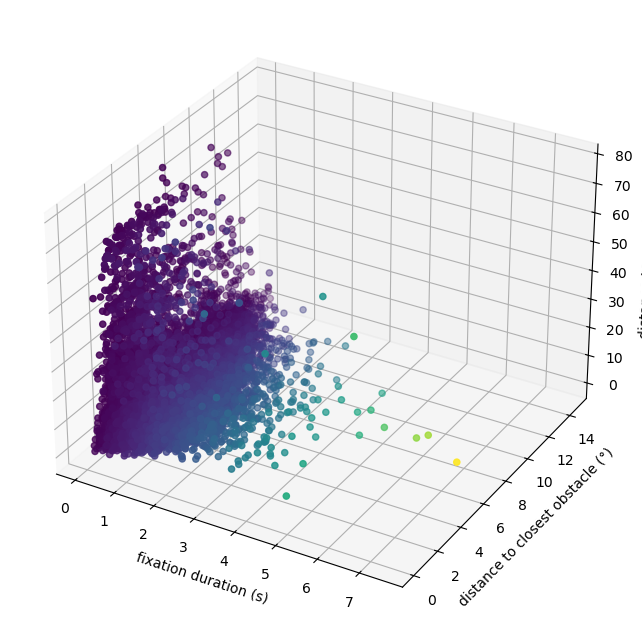

In [7]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection='3d')

ax.set_xlabel("fixation duration (s)")
ax.set_ylabel("distance to closest obstacle (°)")
ax.set_zlabel("distance to agent (°)")

ax.scatter3D(fix_data.fixation_duration, 
             fix_data.Dist_to_closest_obstacle, 
             fix_data.distance_to_spaceship, 
             c=fix_data.fixation_duration, 
             cmap='viridis');

approaching_fixation does not seem to follow any structure...

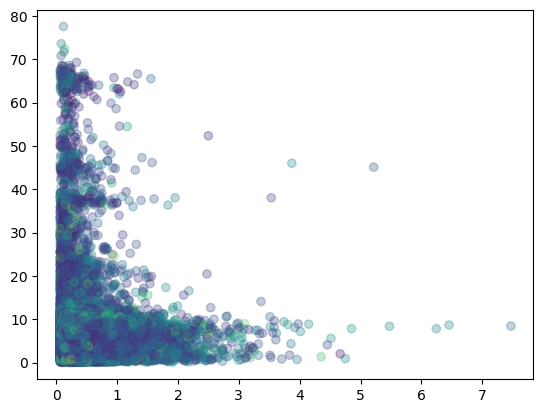

In [8]:
fig, ax = plt.subplots()

ax.scatter(x=fix_data.fixation_duration,
           y=fix_data.distance_to_spaceship, 
           c=fix_data.Dist_to_closest_obstacle, 
           cmap='viridis',
           alpha=0.3)

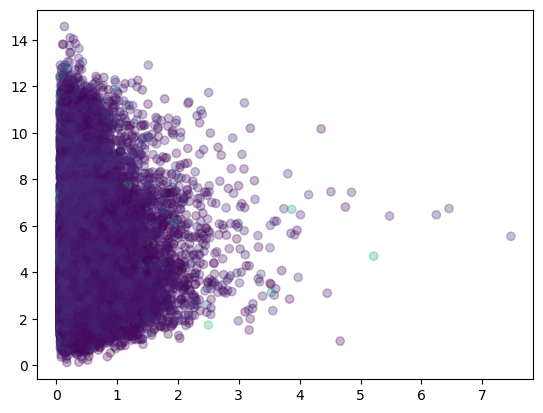

In [9]:
fig, ax = plt.subplots()

ax.scatter(x=fix_data.fixation_duration,
           y=fix_data.Dist_to_closest_obstacle, 
           c=fix_data.distance_to_spaceship, 
           cmap='viridis',
           alpha=0.3)

## Downsampling

Identify and exclude missing values in the three columns of interest.

In [10]:
fix_data_no_missing = fix_data.loc[~(np.isnan(fix_data.fixation_duration)|np.isnan(fix_data.distance_to_spaceship)|np.isnan(fix_data.Dist_to_closest_obstacle))]

## HDBSCAN

In [14]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

In [15]:
X = fix_data_no_missing.loc[:, ['fixation_duration', 'distance_to_spaceship', 'Dist_to_closest_obstacle']].values

In [18]:
X.shape[0]

52772

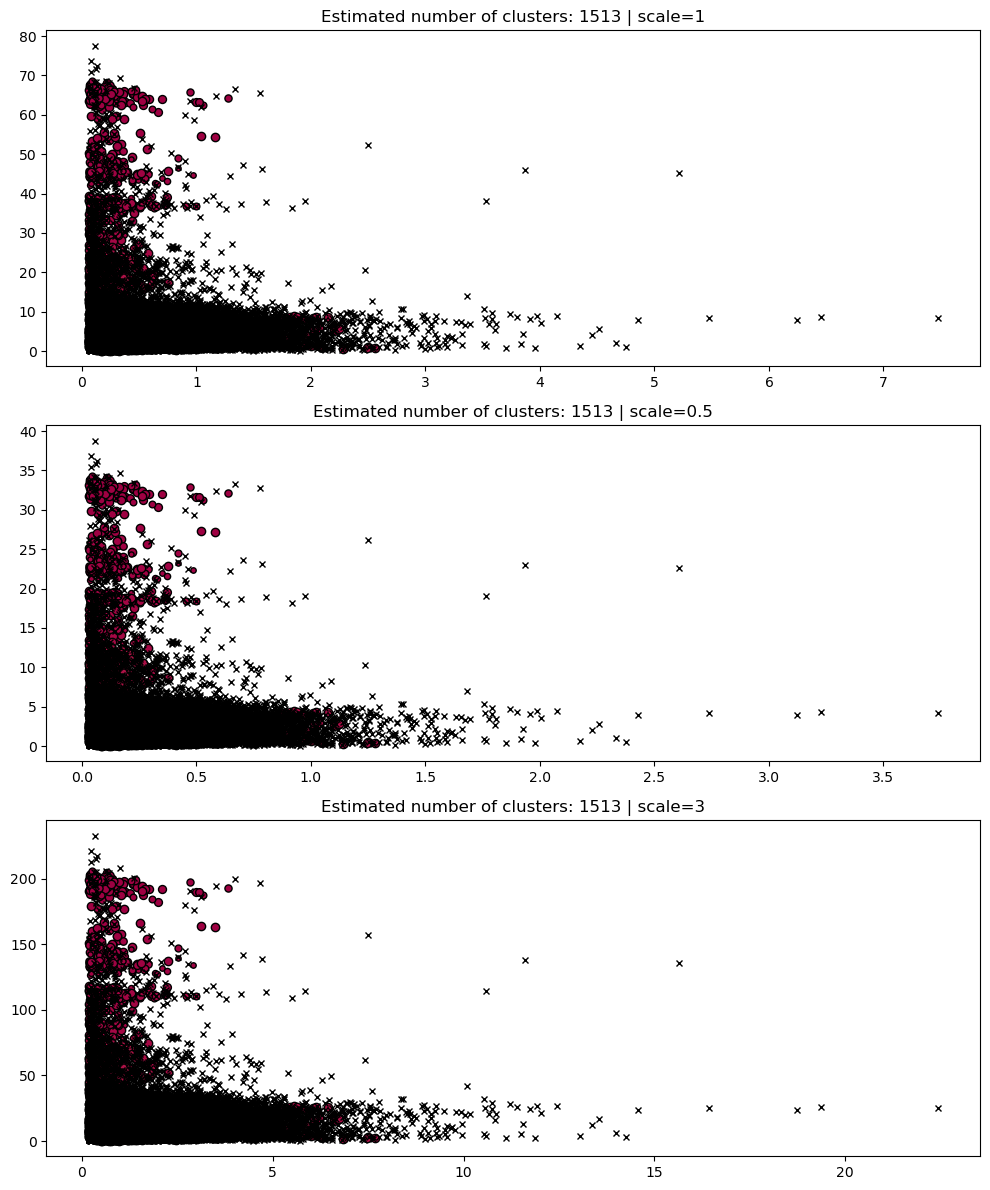

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
hdb = HDBSCAN()
for idx, scale in enumerate([1, 0.5, 3]):
    hdb.fit(X * scale)
    plot(
        X * scale,
        hdb.labels_,
        hdb.probabilities_,
        ax=axes[idx],
        parameters={"scale": scale},
    )

In [20]:
#hdb.labels_,
hdb.probabilities_

array([0.        , 1.        , 0.        , ..., 1.        , 0.98420359,
       0.        ])

In [ ]:
y = fix_data_no_missing.loc[:, ['distant_fixation']].values

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)  # 5 as default
classifier.fit(X_train, y_train)

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [52]:
y_pred = classifier.predict(X_test)

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5407
           1       0.99      0.99      0.99     10425

    accuracy                           0.99     15832
   macro avg       0.99      0.99      0.99     15832
weighted avg       0.99      0.99      0.99     15832

[[ 5326    81]
 [   94 10331]]
